In [ ]:
# prompt: mount to google drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# prompt: merge all csv files in one folder

import pandas as pd
import os
import glob

# Specify the folder containing the CSV files
folder_path = '/content/drive/My Drive/ESDA/econ/data' # Replace with your folder path

# Use glob to find all CSV files in the folder
all_files = glob.glob(os.path.join(folder_path, "*.csv"))

# Create an empty list to store dataframes
df_list = []

# Loop through all CSV files and read them into dataframes
for filename in all_files:
  df = pd.read_csv(filename, sep=';',header=0)
  df.iloc[:, 2] = df.iloc[:, 2].str.replace(',', '.', regex=False).astype(float)


  df_list.append(df)

# Concatenate all dataframes into a single dataframe
merged_df = pd.concat(df_list, axis=0, ignore_index=True)

# Save the merged dataframe to a new CSV file
merged_df.to_csv("/content/drive/My Drive/ESDA/econ/merged_new", index=False)


In [ ]:
merged_df.head()

,Datum von,Datum bis,Deutschland/Luxemburg [€/MWh] Berechnete Auflösungen
0,01.01.2019,02.01.2019,-4.3
1,02.01.2019,03.01.2019,25.92
2,03.01.2019,04.01.2019,57.72
3,04.01.2019,05.01.2019,49.91
4,05.01.2019,06.01.2019,42.18


In [ ]:
import pandas as pd

# --- 1. Drop the first column ---
df1 = merged_df.drop(df.columns[0], axis=1)

# Suppose the second column is now something like:
# "01.01.2019 04:15 - 01.01.2019 04:30 (CET/CEST)"
time_col = df1.columns[0]  # name of the column with time ranges
# df1.column[1]=df1.column[1]+df1.column[2]

# --- 2. Extract just the 'start time' portion from the string ---
# Split on '-' and take the first piece, then remove any leftover text like '(CET/CEST)'
df1['start_str'] = (
    df1[time_col]
    .str.split('-', expand=True)[0]        # take left side of '-'
    .str.replace(r'\(.*\)', '', regex=True)  # remove anything in parentheses
    .str.strip()
)

# --- 3. Convert start_str to actual datetime ---
df1['start_time'] = pd.to_datetime(df1['start_str'], format='%d.%m.%Y %H:%M')

# # If you want just the date (no time), you can make a separate column for grouping
df1['date'] = df1['start_time'].dt.date
df2=df1.drop(df1.columns[0], axis=1)
# --- 4. Group by 'date' and take the mean of remaining columns ---
# (Assuming the rest of your columns are numeric and you want daily averages.)
# daily_means = df2.groupby('date').mean(numeric_only=True)

# print(daily_means)

# daily_means.to_csv("/content/drive/My Drive/ESDA/econ/daily_merged_wind_generation.csv", index=False)


In [ ]:
df2.head()

,Wind Offshore - Actual Aggregated [MW],Wind Onshore - Actual Aggregated [MW],start_str,start_time,date
0,3177.0,19366.0,01.01.2019 00:00,2019-01-01 00:00:00,2019-01-01
1,3174.0,20132.0,01.01.2019 00:15,2019-01-01 00:15:00,2019-01-01
2,3167.0,20863.0,01.01.2019 00:30,2019-01-01 00:30:00,2019-01-01
3,3018.0,21245.0,01.01.2019 00:45,2019-01-01 00:45:00,2019-01-01
4,2862.0,21609.0,01.01.2019 01:00,2019-01-01 01:00:00,2019-01-01


In [ ]:
# prompt: if the first and second column numerical data? if not how to make them numerical


numeric_cols = df2.select_dtypes(include=['number']).columns

if len(numeric_cols) >= 2 and df2.columns[0] in numeric_cols and df2.columns[1] in numeric_cols:
    print("First and second columns are numeric.")
else:
    print("First and second columns are not numeric. Attempting conversion...")

    # Try converting the first two columns to numeric, coercing errors to NaN
    for col in df2.columns[:2]:
        try:
            df2[col] = pd.to_numeric(df2[col], errors='coerce')
        except Exception as e:
            print(f"Could not convert column '{col}' to numeric: {e}")
            # Handle the error as needed, e.g. fill NaN with a specific value

    # Check again if they are now numeric
    numeric_cols = df2.select_dtypes(include=['number']).columns
    if len(numeric_cols) >= 2 and df2.columns[0] in numeric_cols and df2.columns[1] in numeric_cols:
      print("Conversion successful. First and second columns are now numeric.")
    else:
      print("Conversion failed.  First and Second columns are still not numeric.")

    # Further investigation: Check the unique values in non-numeric columns
    for col in df2.columns[:2]:
        if col not in numeric_cols:
          print(f"Unique values in non-numeric column '{col}': {df2[col].unique()}")

df2.head()


First and second columns are not numeric. Attempting conversion...
Conversion successful. First and second columns are now numeric.


,Wind Offshore - Actual Aggregated [MW],Wind Onshore - Actual Aggregated [MW],start_str,start_time,date
0,3177.0,19366.0,01.01.2019 00:00,2019-01-01 00:00:00,2019-01-01
1,3174.0,20132.0,01.01.2019 00:15,2019-01-01 00:15:00,2019-01-01
2,3167.0,20863.0,01.01.2019 00:30,2019-01-01 00:30:00,2019-01-01
3,3018.0,21245.0,01.01.2019 00:45,2019-01-01 00:45:00,2019-01-01
4,2862.0,21609.0,01.01.2019 01:00,2019-01-01 01:00:00,2019-01-01


In [ ]:
# prompt: take the mean by date of the first and the socond column

# --- 4. Group by 'date' and take the mean of the first two columns ---
daily_means = df2.groupby('date')[df2.columns[0:2]].mean(numeric_only=True)

daily_means.head()



,Wind Offshore - Actual Aggregated [MW],Wind Onshore - Actual Aggregated [MW]
date,,
2019-01-01,2287.937500,31497.989583
2019-01-02,3169.927083,25610.239583
2019-01-03,2664.406250,9629.572917
2019-01-04,3672.354167,18485.843750
2019-01-05,3702.583333,21849.343750


In [ ]:
# prompt: make a column name as Wind Total, which is sum of second and the third column, then save the csv to file

# Assuming df2 is your dataframe from the previous code
# and it has at least two numeric columns after the necessary conversions.


if len(df2.select_dtypes(include=['number']).columns) >= 2:
    df2['Wind Total'] = df2.iloc[:, 0] + df2.iloc[:, 1]
    daily_means = df2.groupby('date').agg({'Wind Total':'mean'})
    print(daily_means.head())
    daily_means.to_csv("/content/drive/My Drive/ESDA/econ/daily_merged_wind_generation_total.csv", index=True)
else:
    print("Not enough numeric columns to calculate 'Wind Total'. Please check the data.")


              Wind Total
date                    
2019-01-01  33785.927083
2019-01-02  28780.166667
2019-01-03  12293.979167
2019-01-04  22158.197917
2019-01-05  25551.927083


In [ ]:
# prompt: drop the data after date 2024-12-31

import pandas as pd
# Assuming 'daily_means' is your dataframe with a 'date' index
daily_means = daily_means[daily_means.index <= pd.to_datetime('2024-12-31').date()]
daily_means


,Wind Total
date,
2019-01-01,33785.927083
2019-01-02,28780.166667
2019-01-03,12293.979167
2019-01-04,22158.197917
2019-01-05,25551.927083
...,...
2024-12-27,1957.104167
2024-12-28,2203.562500
2024-12-29,14715.062500


In [ ]:
daily_means.to_csv("/content/drive/My Drive/ESDA/econ/daily_wind_generation_total.csv", index=True)

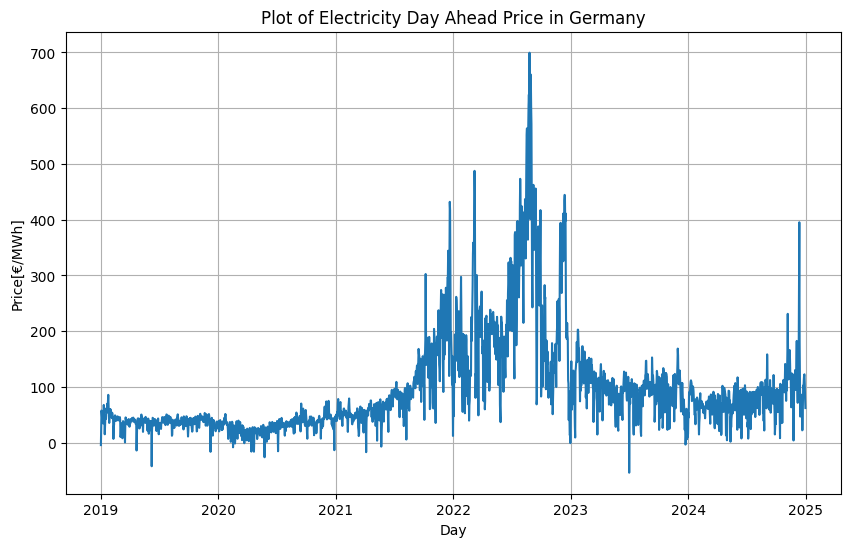

In [ ]:
# prompt: plot merged data

import matplotlib.pyplot as plt

merged_df['Datum von'] = pd.to_datetime(merged_df['Datum von'], format='%d.%m.%Y')
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.plot(merged_df['Datum von'], merged_df['Deutschland/Luxemburg [€/MWh] Berechnete Auflösungen'])
plt.xlabel('Day')
plt.ylabel('Price[€/MWh]')
plt.title('Plot of Electricity Day Ahead Price in Germany')
plt.grid(True)
plt.show()



In [ ]:
# prompt: i wan to plot the price,the x label should be aggragated year, the first column is Datum von, in dd.mm.yyyy format

import matplotlib.pyplot as plt

# Assuming 'daily_means' is your DataFrame with a 'date' index and a 'Wind Total' column.
# Also assuming 'daily_means' has already been filtered and saved to the correct CSV file.

plt.figure(figsize=(12, 6))
plt.plot(daily_means.index, daily_means['Wind Total'])  # Plot 'Wind Total' against the date index

# Format the x-axis to show years
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True)) # Ensures integer year ticks
plt.xlabel('Year')
plt.ylabel('Average Wind Total')  # Update y-axis label
plt.title('Average Daily Wind Total over Time')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()


In [ ]:
merged_df.head()

,Datum von,Datum bis,Deutschland/Luxemburg [€/MWh] Berechnete Auflösungen
0,2019-01-01,02.01.2019,-4.3
1,2019-01-02,03.01.2019,25.92
2,2019-01-03,04.01.2019,57.72
3,2019-01-04,05.01.2019,49.91
4,2019-01-05,06.01.2019,42.18


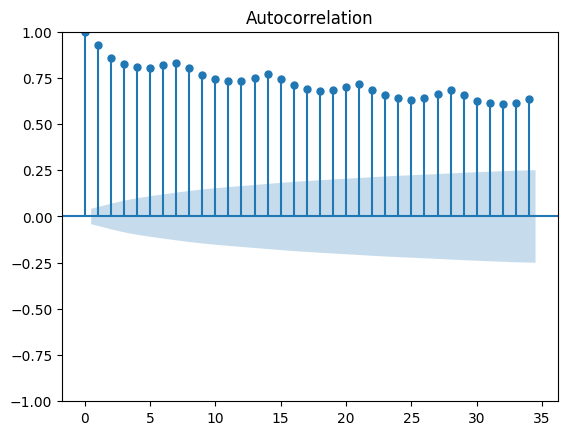

In [ ]:
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(merged_df['Deutschland/Luxemburg [€/MWh] Berechnete Auflösungen'])
pyplot.show()

In [ ]:
# prompt: print Descriptive statistics of df_p should include：
#                                 Mean
#                                 Std.Dev.
#                                 Skewness
#                                 Kurtosis
#                                 Jarque-Bera
#                                 Prob.

import pandas as pd
import scipy.stats as stats
from statsmodels.stats.stattools import jarque_bera
# descriptive_stats = merged_df['Deutschland/Luxemburg [€/MWh] Berechnete Auflösungen'].describe()

mean=merged_df['Deutschland/Luxemburg [€/MWh] Berechnete Auflösungen'].mean()
std=merged_df['Deutschland/Luxemburg [€/MWh] Berechnete Auflösungen'].std()

skewness = merged_df['Deutschland/Luxemburg [€/MWh] Berechnete Auflösungen'].skew()
kurtosis = merged_df['Deutschland/Luxemburg [€/MWh] Berechnete Auflösungen'].kurt()

# Calculate Jarque-Bera test
# jb_test = merged_df['Deutschland/Luxemburg [€/MWh] Berechnete Auflösungen'].apply(jarque_bera)

# stats.jarque_bera(merged_df['Deutschland/Luxemburg [€/MWh] Berechnete Auflösungen'])


In [ ]:
print('Mean :'+ str(mean) + ', Std.Dev. :'+ str(std) + ', Skewness :'+ str(skewness) + ', Kurtosis :'+ str(kurtosis))

Mean :95.65025547445272, Std.Dev. :92.46559097772206, Skewness :2.444772685592609, Kurtosis :7.5549814717304296


In [ ]:
# Convert the column to numeric, handling potential errors
merged_df['Deutschland/Luxemburg [€/MWh] Berechnete Auflösungen'] = pd.to_numeric(
    merged_df['Deutschland/Luxemburg [€/MWh] Berechnete Auflösungen'])

jb_test =stats.jarque_bera(merged_df['Deutschland/Luxemburg [€/MWh] Berechnete Auflösungen'])
print(jb_test)

In [ ]:
# prompt: Dickey-Fuller
#  test

from statsmodels.tsa.stattools import adfuller

# Assuming 'daily_means' is your DataFrame with 'Wind Total'
# Replace 'Wind Total' with your actual column name if different
result = adfuller(df_wind['Wind Total'])

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[1] <= 0.05:
    print("Reject the null hypothesis. The time series is stationary.")
else:
    print("Fail to reject the null hypothesis. The time series is non-stationary.")


ADF Statistic: -6.795198
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Reject the null hypothesis. The time series is stationary.


In [ ]:
print(result)

(-2.876101332101646, 0.048198504446297606, 26, 2165, {'1%': -3.4333740509447717, '5%': -2.8628759187993382, '10%': -2.567481176655697}, 20952.24686011754)


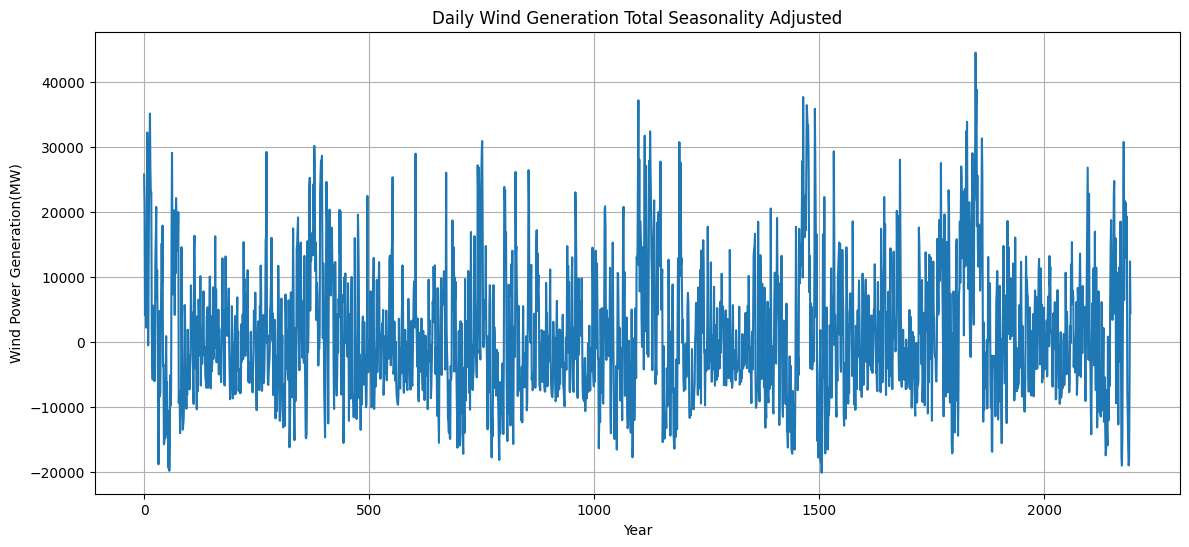

In [ ]:
# prompt: plot /content/drive/MyDrive/ESDA/econ/daily_wind_generation_total.csv, for x axis , do not shoe date , only show year

from matplotlib import pyplot
import matplotlib.pyplot as plt


# Plot the data with years on the x-axis
plt.figure(figsize=(14, 6))
plt.plot(merged_df['wind_Adjusted'])
plt.xlabel('Year')
plt.ylabel('Wind Power Generation(MW)')
plt.title('Daily Wind Generation Total Seasonality Adjusted')
plt.grid(True)
plt.show()


In [ ]:
# Assuming df_p is your DataFrame
descriptive_stats = df_wind['Wind Total'].describe()

# Calculate skewness and kurtosis
skewness = df_wind['Wind Total'].skew()
kurtosis = df_wind['Wind Total'].kurt()

mean = df_wind['Wind Total'].mean()
std = df_wind['Wind Total'].std()

print('Mean :'+ str(mean) + ', Std.Dev. :'+ str(std) + ', Skewness :'+ str(skewness) + ', Kurtosis :'+ str(kurtosis))

Mean :14730.240990946988, Std.Dev. :10003.20805099712, Skewness :0.9098304337877311, Kurtosis :0.10392903334522519


In [ ]:
stats.jarque_bera(df_wind['Wind Total'])

SignificanceResult(statistic=302.936847754329, pvalue=1.6523396619014242e-66)

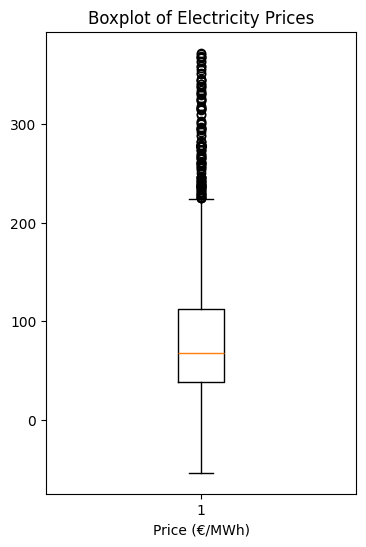

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df_p=pd.read_csv('/content/drive/MyDrive/ESDA/econ/merged_file.csv')

# Assuming df_p is your DataFrame with the 'price' column
plt.figure(figsize=(4, 6))
plt.boxplot(merged_df['Deutschland/Luxemburg [€/MWh] Berechnete Auflösungen'], vert=True)  # vert=False for horizontal boxplot
plt.xlabel('Price (€/MWh)')
plt.title('Boxplot of Electricity Prices')
plt.show()


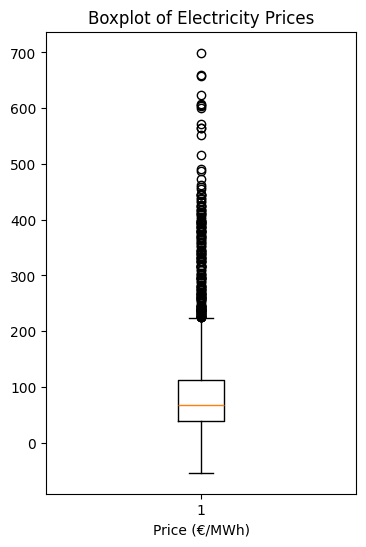

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming df_p is your DataFrame with the 'price' column
plt.figure(figsize=(4, 6))
plt.boxplot(df_p['Deutschland/Luxemburg [€/MWh] Berechnete Auflösungen'], vert=True)  # vert=False for horizontal boxplot
plt.xlabel('Price (€/MWh)')
plt.title('Boxplot of Electricity Prices')
plt.show()

In [ ]:

result = adfuller(df_p['Deutschland/Luxemburg [€/MWh] Berechnete Auflösungen'])

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[1] <= 0.05:
    print("Reject the null hypothesis. The time series is stationary.")
else:
    print("Fail to reject the null hypothesis. The time series is non-stationary.")


ADF Statistic: -2.876101
p-value: 0.048199
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Reject the null hypothesis. The time series is stationary.


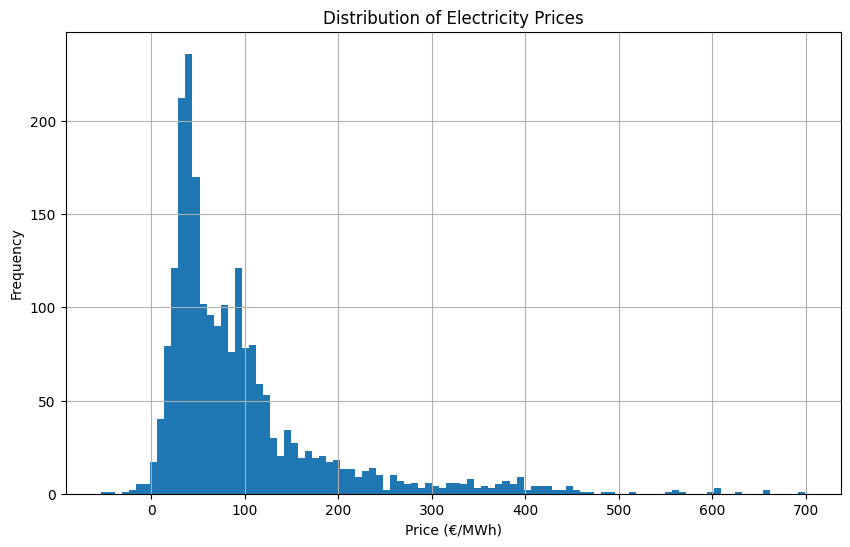

In [ ]:

plt.figure(figsize=(10, 6))
plt.hist(merged_df['Deutschland/Luxemburg [€/MWh] Berechnete Auflösungen'], bins=100)  # Adjust the number of bins as needed
plt.xlabel('Price (€/MWh)')
plt.ylabel('Frequency')
plt.title('Distribution of Electricity Prices')
plt.grid(True)
plt.show()


In [ ]:

import numpy as np
# Calculate mean and standard deviation of the column
mean_val = merged_df['Deutschland/Luxemburg [€/MWh] Berechnete Auflösungen'].mean()
std_val = merged_df['Deutschland/Luxemburg [€/MWh] Berechnete Auflösungen'].std()

# Define the cutoff for outliers as mean +/- 3 * std
upper_bound = mean_val + 3 * std_val
lower_bound = mean_val - 3 * std_val

# Replace outliers with +3*std for high outliers, and -3*std for low outliers
merged_df.loc[merged_df['Deutschland/Luxemburg [€/MWh] Berechnete Auflösungen'] > upper_bound, 'Deutschland/Luxemburg [€/MWh] Berechnete Auflösungen'] = 3 * std_val
merged_df.loc[merged_df['Deutschland/Luxemburg [€/MWh] Berechnete Auflösungen'] < lower_bound, 'Deutschland/Luxemburg [€/MWh] Berechnete Auflösungen'] = -3 * std_val

merged_df.to_csv("/content/drive/My Drive/ESDA/econ/outlier_removed_merged", index=False)


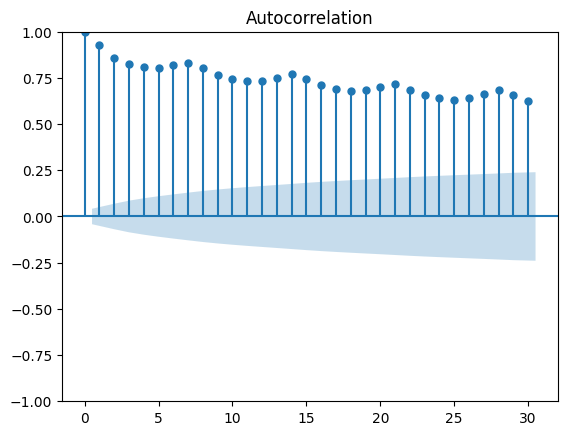

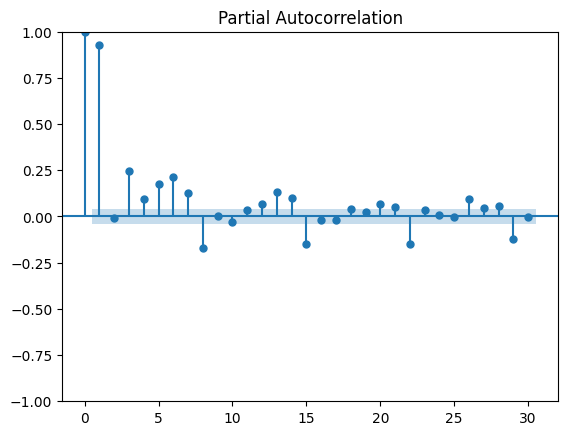

In [ ]:
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plot_acf(df_p['Deutschland/Luxemburg [€/MWh] Berechnete Auflösungen'], lags=30)

plot_pacf(df_p['Deutschland/Luxemburg [€/MWh] Berechnete Auflösungen'],lags=30)
pyplot.show()

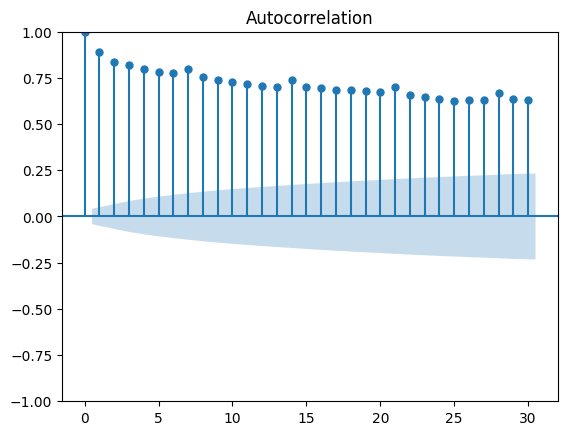

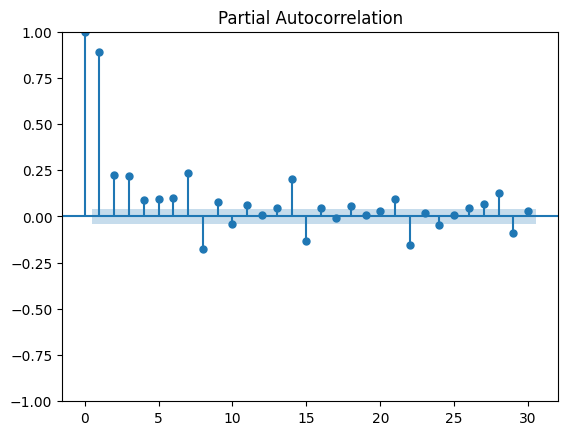

In [ ]:
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plot_acf(merged_df['Price_Adjusted'], lags=30)

plot_pacf(merged_df['Price_Adjusted'],lags=30)
pyplot.show()

In [ ]:
merged_df.head()

,Datum von,Datum bis,Deutschland/Luxemburg [€/MWh] Berechnete Auflösungen
0,01.01.2019,02.01.2019,-4.30
1,02.01.2019,03.01.2019,25.92
2,03.01.2019,04.01.2019,57.72
3,04.01.2019,05.01.2019,49.91
4,05.01.2019,06.01.2019,42.18


In [ ]:
import numpy as np
import statsmodels.api as sm

# Suppose df has:
#   'Date' - a datetime column (format: dd.mm.yyyy or similar)
#   'Price' - the electricity price

# 1) Parse and set date if not already done
merged_df['Datum von'] = pd.to_datetime(merged_df['Datum von'], format='%d.%m.%Y')

# 2) Identify seasonal patterns
#    - day of week (Monday=0, Sunday=6)
#    - month (January=1, December=12)
merged_df['DayOfWeek'] = merged_df['Datum von'].dt.dayofweek  # 0=Monday, ..., 6=Sunday
merged_df['Month'] = merged_df['Datum von'].dt.month         # 1=January, ..., 12=December
merged_df['Year'] = merged_df['Datum von'].dt.year        # 1=January, ..., 12=December
# 3) Create dummy variables
#    To avoid the dummy variable trap, drop the first category in each set
day_dummies = pd.get_dummies(merged_df['DayOfWeek'], prefix='Day', drop_first=True)
month_dummies = pd.get_dummies(merged_df['Month'], prefix='Month', drop_first=True)
year_dummies = pd.get_dummies(merged_df['Year'], prefix='Year', drop_first=True)
# 4) Combine dummies into your design matrix (X)
#    You could also include other regressors if you want
X = pd.concat([day_dummies,month_dummies,year_dummies], axis=1)
# X = sm.add_constant(X)  # add an intercept term

y = merged_df['Deutschland/Luxemburg [€/MWh] Berechnete Auflösungen']

# 5) Regress Price on the seasonality dummies
model = sm.OLS(y, X).fit()

# 6) Get the residuals: these are your seasonally adjusted prices
merged_df['Price_Adjusted'] = model.resid

# 7) Check or plot the residuals
print(merged_df['Price_Adjusted'].head())

# 8) (Optional) Run ADF on the adjusted series
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(merged_df['Price_Adjusted'])
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Test Critical Values: :", adf_result[4])



0   -43.517239
1   -12.499290
2    20.940562
3    16.976682
4    25.140961
Name: Price_Adjusted, dtype: float64
ADF Statistic: -2.950576582540795
p-value: 0.039774850963966824
Test Critical Values: : {'1%': -3.4333740509447717, '5%': -2.8628759187993382, '10%': -2.567481176655697}


In [ ]:
df_wind.head()

,Wind Total,year
date,,
2019-01-01,33785.927083,2019
2019-01-02,28780.166667,2019
2019-01-03,12293.979167,2019
2019-01-04,22158.197917,2019
2019-01-05,25551.927083,2019


In [ ]:
# df_wind['date'] = pd.to_datetime(df_wind['date'], format='%Y-%m-%d')

# 2) Identify seasonal patterns
#    - day of week (Monday=0, Sunday=6)
#    - month (January=1, December=12)

df_wind['Month'] = df_wind.index.month            # e.g. 1 to 12
df_wind['DayOfWeek'] = df_wind.index.dayofweek    # Monday=0 ... Sunday=6
# 3) Create dummy variables
#    To avoid the dummy variable trap, drop the first category in each set
day_dummies = pd.get_dummies(df_wind['DayOfWeek'], prefix='Day', drop_first=True)
month_dummies = pd.get_dummies(df_wind['Month'], prefix='Month', drop_first=True)

# 4) Combine dummies into your design matrix (X)
#    You could also include other regressors if you want
X = pd.concat([day_dummies,month_dummies], axis=1)
# X = sm.add_constant(X)  # add an intercept term

y = df_wind['Wind Total']

# 5) Regress Price on the seasonality dummies
model = sm.OLS(y, X).fit()

# 6) Get the residuals: these are your seasonally adjusted prices
df_wind['wind_Adjusted'] = model.resid

# 7) Check or plot the residuals
print(df_wind['wind_Adjusted'].head())

# 8) (Optional) Run ADF on the adjusted series
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(df_wind['wind_Adjusted'])
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Test Critical Values: :", adf_result[4])

date
2019-01-01    25747.039534
2019-01-02    21029.130692
2019-01-03     4049.347398
2019-01-04    13443.712697
2019-01-05    17320.434217
Name: wind_Adjusted, dtype: float64
ADF Statistic: -7.908252519876578
p-value: 4.012161765533748e-12
Test Critical Values: : {'1%': -3.4333684674663467, '5%': -2.8628734534635902, '10%': -2.5674798640234444}


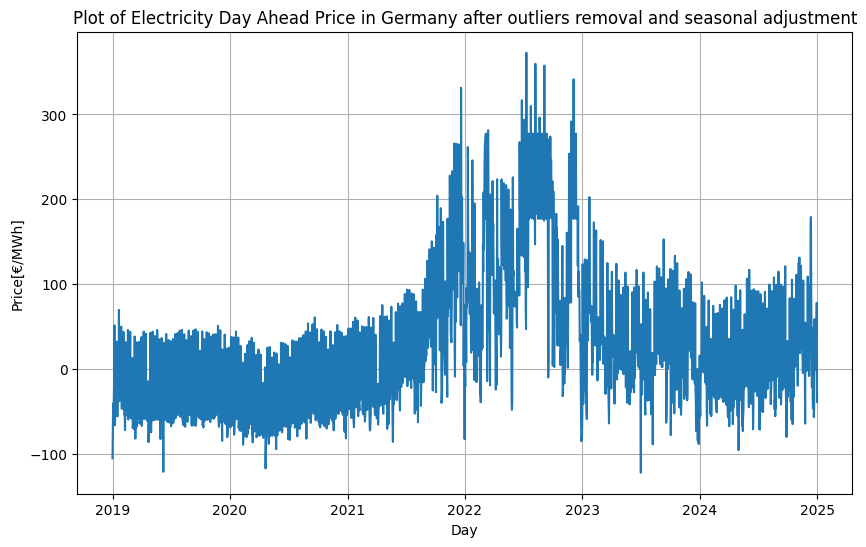

In [ ]:
import matplotlib.pyplot as plt

merged_df['Datum von'] = pd.to_datetime(merged_df['Datum von'], format='%d.%m.%Y')
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.plot(merged_df['Datum von'], merged_df['Price_Adjusted'])
plt.xlabel('Day')
plt.ylabel('Price[€/MWh]')
plt.title('Plot of Electricity Day Ahead Price in Germany after outliers removal and seasonal adjustment')
plt.grid(True)
plt.show()


In [ ]:
# df_wind.head()
merged_df['wind_Adjusted']=df_wind['wind_Adjusted'].values
merged_df.head()

,Datum von,Datum bis,Deutschland/Luxemburg [€/MWh] Berechnete Auflösungen,DayOfWeek,Month,Price_Adjusted,wind_Adjusted
0,2019-01-01,02.01.2019,-4.30,1,1,-43.517239,25747.039534
1,2019-01-02,03.01.2019,25.92,2,1,-12.499290,21029.130692
2,2019-01-03,04.01.2019,57.72,3,1,20.940562,4049.347398
3,2019-01-04,05.01.2019,49.91,4,1,16.976682,13443.712697
4,2019-01-05,06.01.2019,42.18,5,1,25.140961,17320.434217


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Best AR lag (p) according to AIC is: 13
Best AIC: 20665.01

Summary of the best ARMAX model:
                               SARIMAX Results                                
Dep. Variable:         Price_Adjusted   No. Observations:                 2192
Model:              SARIMAX(13, 0, 0)   Log Likelihood              -10317.506
Date:                Fri, 14 Mar 2025   AIC                          20665.013
Time:                        17:15:02   BIC                          20750.312
Sample:                             0   HQIC                         20696.197
                               - 2192                                         
Covariance Type:                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
wind_Adjusted    -0.0020   6.67e-05    -29.525      0.000      -0.002      -0.002
ar.L1             0.5996     

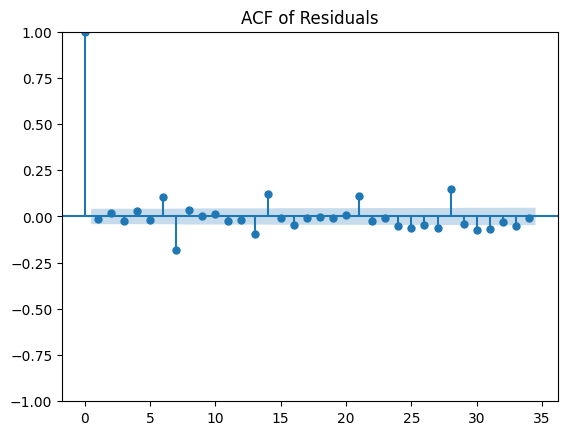

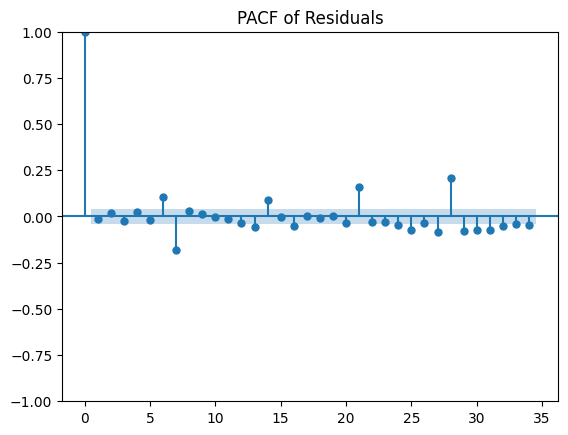

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX



# Separate the dependent (endog) variable and the exogenous (exog) variable
endog = merged_df['Price_Adjusted']
exog = merged_df['wind_Adjusted']  # if you have multiple exogenous vars, include them here

# ----------------------------------------------------------------------------
# 2) Determine the best AR lag p by minimizing AIC
#    We fix d=0 and q=0, so it's effectively an AR(p) with exogenous regressors
# ----------------------------------------------------------------------------
p_candidates = range(1, 14)  # for example, try p from 1 to 13

best_p = None
best_aic = float('inf')
best_model = None

for p in p_candidates:
    try:
        # Fit ARMAX as SARIMAX with order=(p,0,0)
        model = SARIMAX(endog=endog, exog=exog, order=(p, 0, 0),
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        results = model.fit(disp=False)

        if results.aic < best_aic:
            best_aic = results.aic
            best_p = p
            best_model = results
    except Exception as e:
        # If the model fails to converge for some p, just skip it
        print(f"Warning: AR({p}) model failed to fit.\nError: {e}")
        continue

print(f"Best AR lag (p) according to AIC is: {best_p}")
print(f"Best AIC: {best_aic:.2f}")

# ----------------------------------------------------------------------------
# 3) Final Model with p=7 (assuming that's indeed the best)
# ----------------------------------------------------------------------------
print("\nSummary of the best ARMAX model:")
print(best_model.summary())

# ----------------------------------------------------------------------------
# 4) Diagnostics: Fitted values, Residuals, Plots
# ----------------------------------------------------------------------------
merged_df['Fitted'] = best_model.fittedvalues
merged_df['Residuals'] = best_model.resid

# # Plot actual Price vs. Fitted
# df[['Price', 'Fitted']].plot()
# plt.title(f'AR({best_p}) Model: Actual vs Fitted Electricity Prices')
# plt.xlabel('Date')
# plt.ylabel('Price')
# plt.show()

# # Histogram of residuals
# df['Residuals'].plot(kind='hist', bins=30)
# plt.title('Histogram of Residuals')
# plt.show()

# Autocorrelation of residuals can be further checked with statsmodels ACF/PACF:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(merged_df['Residuals'].dropna())
plt.title('ACF of Residuals')
plt.show()

plot_pacf(merged_df['Residuals'].dropna())
plt.title('PACF of Residuals')
plt.show()


In [ ]:


# Separate the dependent (endog) variable and the exogenous (exog) variable
endog = merged_df['Price_Adjusted'][0:730]
exog = merged_df['wind_Adjusted'][0:730] # if you have multiple exogenous vars, include them here

model = SARIMAX(endog=endog, exog=exog, order=(7, 0, 0),
                        enforce_stationarity=False,
                        enforce_invertibility=False)
results = model.fit(disp=False)
print("\nSummary of the best ARMAX model:")
print(results.summary())



Summary of the best ARMAX model:
                               SARIMAX Results                                
Dep. Variable:         Price_Adjusted   No. Observations:                  730
Model:               SARIMAX(7, 0, 0)   Log Likelihood               -2914.443
Date:                Fri, 14 Mar 2025   AIC                           5846.887
Time:                        18:20:27   BIC                           5888.138
Sample:                             0   HQIC                          5862.809
                                - 730                                         
Covariance Type:                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
wind_Adjusted    -0.0005    5.3e-05     -9.484      0.000      -0.001      -0.000
ar.L1             0.3465      0.024     14.241      0.000       0.299       0.394
ar.L2 

In [ ]:
import pandas as pd
import numpy as np
from arch import arch_model
import statsmodels.api as sm

# Example dataset structure (your own real data goes here)
# Assume df is your DataFrame with 'price' and 'wind' columns:
# df = pd.read_csv('your_data.csv')

# For demonstration, let's create a dummy dataset:
np.random.seed(42)
n_obs = 1000
df = pd.DataFrame({
    'price': np.random.randn(n_obs).cumsum() + 50,
    'wind': np.random.randn(n_obs).cumsum() + 20
})

# Calculate returns or differences if non-stationary
df['price_diff'] = df['price'].diff().dropna()
df['wind_diff'] = df['wind'].diff().dropna()

df = df.dropna()

# Define the mean model with ARMA(1,1) and wind generation as external regressor
X_mean = sm.add_constant(df['wind_diff'])
mean_model = sm.tsa.ARIMA(df['price_diff'], order=(1,0,1), exog=X_mean).fit()

# Get residuals from mean model
residuals = mean_model.resid

# GARCH-X model (with wind generation influencing volatility)
# Specify external regressor for variance equation
X_volatility = df['wind_diff']

# Arch library's arch_model supports GARCH-X with external regressors in variance
garch_model = arch_model(
    residuals,
    mean='Zero',  # Already modeled mean separately
    vol='GARCH',
    p=1,
    q=1,
    x=X_volatility,
    dist='normal'
)

# Fit the GARCH-X model
garch_result = garch_model.fit(disp='off')

# Print results
print("=== Mean Model (ARMA-X) Results ===")
print(mean_model.summary())

print("\n=== Volatility Model (GARCH-X) Results ===")
print(garch_result.summary())

# Optional: visualize conditional volatility
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(garch_result.conditional_volatility, label='Conditional Volatility')
ax.set_title('Conditional Volatility from GARCH-X Model')
ax.legend()
plt.show()
